# Transformers for Text Generation 


- Implement Transformers for text generation tasks
- Build, train, and evaluate Transformer models for text generation using TensorFlow and Keras
- Apply text generation in real-world scenarios

#### Step 1: Set up the environment

In [3]:
import tensorflow as tf
import numpy as np
# from tensorflow.keras.layers import TextVectorization
try:
    from tensorflow.keras.layers import TextVectorization
except ImportError:
    from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

from tensorflow.keras.utils import get_file

# Load the dataset
path_to_file = get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt') 
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')

# Preview the dataset
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [4]:
# Preprocess the data
vocab_size = 10000 # Above 10000 for a dataset like this may result to overfitting and waste of memory.
seq_length = 100

# Adapt TextVectorization to full text
vectorizer = TextVectorization(max_tokens=vocab_size, output_mode='int') # Create a TextVectorization layer that will convert text → integer sequences
text_ds = tf.data.Dataset.from_tensor_slices([text]).batch(1) # Put the whole text into a dataset (needed for the vectorizer to learn the words)
vectorizer.adapt(text_ds) # Teach the vectorizer what words exist in the text and how often they appear


# Vectorize the text
vectorized_text = vectorizer([text])[0] # Turn the text into a list of numbers (one number per word)
print("Vectorized text shape: ", vectorized_text.shape) # Show how many numbers (words) are in the text
print("First 10 vectorized tokens: ", vectorized_text.numpy()[:10]) # Show the first 10 numbers as an example

Vectorized text shape:  (202646,)
First 10 vectorized tokens:  [ 89 270 138  36 982 144 673 125  16 106]


The Shakespeare dataset has 202,646 word tokens in total, and the model learns from only 10,000 out of the 202,646

In the code above: 

1. Built a vocabulary (up to 10,000 unique words).
 - The vectorizer scans the whole Shakespeare text and figures out the most common words. 
 - Each word gets an ID number (e.g., "the" → 5, "love" → 28) (the numbers are assigned on how common these words appear, the more common the lower. [Also starts from 2, as 0 and 1 are reserved for padding and out of vocabulary tokens])

2. Convert text → integers.
 - The raw words in the play are replaced with their IDs.
 - Instead of: "To be or not to be" You get something like: [89, 270, 138, 36, 982, 144]

3. Prepare for the model.
 - Neural networks can’t process raw text.
 - By turning words into numbers, we can feed them into an embedding layer (which turns each word ID into a vector of floats) → then into a Transformer.

#### Step 2: Create input and target sequences

Generate input and target sequences for training the Transformer model.

In [5]:
def create_sequences(text, seq_length):
    # These will store many training examples
    input_seqs = [] # inputs the model sees
    target_seqs =[] # correct answers the model should predict
    
    # Slide a window of length `seq_length` across the text
    for i in range(len(text) - seq_length):
        # Input = current window of tokens
        input_seq = text[i:i + seq_length]
        # Target = same window but shifted by one token
        # This makes the "next word prediction" task
        target_seq = text[i + 1:i + seq_length + 1]
        # Save them
        input_seqs.append(input_seq)
        target_seqs.append(target_seq)
    # Convert lists into arrays (for TensorFlow to use)
    return np.array(input_seqs), np.array(target_seqs)

# Generate sequences
# Create input/output pairs from the vectorized Shakespeare text
X, Y = create_sequences(vectorized_text.numpy(), seq_length)

# Check if sequences are correctly generated 

# Show how many training pairs we built
print("Number of sequences generated: ", len(X))
# Show the first input sequence (just for inspection)
print("Sample input sequence: ", X[0] if len(X) > 0 else "No sequences generated")

# Check if X and Y are not empty
# Make sure nothing went wrong (no empty data)
assert X.size > 0, "Input data X is empty"
assert Y.size > 0, "Target data Y is empty"

# Convert arrays into TensorFlow tensors (so they can go into a model)
X = tf.convert_to_tensor(X)
Y = tf.convert_to_tensor(Y)

# Print the final shapes
print("Shape of X: ", X.shape)
print("Shape of Y: ", Y.shape)

Number of sequences generated:  202546
Sample input sequence:  [  89  270  138   36  982  144  673  125   16  106   34  106  106   89
  270    7   41   34 1286  344    4  200   64    4 3690   34 1286 1286
   89  270   89    7   93 1187  225   12 2442  592    4    2  307   34
   36 2655   36 2655   89  270   72   79  506   27    3   56   24 1390
   57   40  161 2328  644    9 4980   34   32   54 2863  885   72   17
   18  163  146  146  165  270   74  218   46  595   89  270   36   41
 6739  172  595    2 1780   46   29 1323 5151   47   58 4151   79   39
   60   58]
Shape of X:  (202546, 100)
Shape of Y:  (202546, 100)


1. The Goal
    We want the model to learn how to predict the next word in a sequence of text.
To do that, we need to turn our long vector of words (202,646 tokens) into training examples.

2. The Sliding Window
    The function create_sequences(text, seq_length) creates a sliding window of length seq_length (say 100) across the text.

    For each position i:
    
        Input sequence (X) = tokens from i to i + seq_length
        Target sequence (Y) = the same tokens but shifted one step to the right

    So the model is asked:
    👉 “If you see this chunk of text, what comes next?”

3. Example (small numbers)
    If text = [10, 20, 30, 40, 50] and seq_length = 3:
        Step 0:
            Input = [10, 20, 30]
            Target = [20, 30, 40]

        Step 1:
            Input = [20, 30, 40]
            Target = [30, 40, 50]

        So we get:
            X = [[10,20,30], [20,30,40]]
            Y = [[20,30,40], [30,40,50]]

4. Why Do This?
    - The model doesn’t just learn single-word predictions.

    - It learns from overlapping contexts — every word appears many times in different positions.

    - By training on millions of these pairs, the model picks up grammar, style, and sequence patterns.

✅ In plain English:
This code chops the text into many overlapping “questions and answers.”

    - The question (X) = “Here are 100 words in order.”
    - The answer (Y) = “Here are the next 100 words (shifted by one).”
    The model learns this mapping so it can predict the next word when generating text.

Decode the IDs into words, so we can see what actaully is happening

In [6]:
# Get the vocabulary list from the vectorizer
# index -> word mapping
vocab = vectorizer.get_vocabulary()

# Sample input sequence (the numbers you printed)
sample_sequence = X[0].numpy()

# Decode numbers back into words
decoded_words = [vocab[token_id] for token_id in sample_sequence]

# Join into a readable string
decoded_text = " ".join(decoded_words)

print("Decoded sequence:\n", decoded_text)


Decoded sequence:
 first citizen before we proceed any further hear me speak all speak speak first citizen you are all resolved rather to die than to famish all resolved resolved first citizen first you know caius marcius is chief enemy to the people all we knowt we knowt first citizen let us kill him and well have corn at our own price ist a verdict all no more talking ont let it be done away away second citizen one word good citizens first citizen we are accounted poor citizens the patricians good what authority surfeits on would relieve us if they would


#### Step 3: Build the Transformer model

Define the Transformer model architecture for text generation. 

In the following code:
 - Define the TransformerBlcok class that includes multi-head attention and feedforward layers with normalization and dropout.
 - Define the TransformerModel class, including embedding, positional encoding, and multiple Transformer blocks.
 - Compile the Transformer model using Adam optimizer and sparse categorical cross-entropy loss function. 

In [48]:
from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense, LayerNormalization, Dropout
from tensorflow.keras.models import Model

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        # Multi-head attention: "what should I focus on?"
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        # Feed-forward network: expand -> process -> compress
        self.ffn = tf.keras.Sequential([
            # Dense(ff_dim, activation="relu"), # Expand and activate
            Dense(ff_dim, activation="leaky_relu"), # Expand and activate
            Dense(embed_dim) # Compress back to original
        ])
        # Layer normalization: keeps values stable during training
        self.layernorm1 = LayerNormalization(epsilon = 1e-6)
        self.layernorm2 = LayerNormalization(epsilon = 1e-6)
        # Dropout: randomly zero some values to prevent overfitting
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        # Step 1: Self-attention - each word looks at all other words
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output) # Add & normalize (residual connection)
        # Step 2: Feed-forward processing
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output) # Add & normalize again
    
class TransformerModel(Model): 
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, num_layers, seq_length):
        super(TransformerModel, self).__init__()
        # Convert word IDs to dense vectors
        self.embedding = Embedding(vocab_size, embed_dim)
        # Add position information (since attention ignores word order)
        self.pos_encoding = self.positional_encoding(seq_length, embed_dim)
        # Stack multiple transformer blocks for deeper processing
        self.transformer_blocks = [TransformerBlock(embed_dim, num_heads, ff_dim) for _ in range (num_layers)]
        # Final layer: convert back to vocabulary predictions
        self.dense = Dense(vocab_size)

    def positional_encoding(self, seq_length, embed_dim):
        # Calculate angles for sine/cosine functions
        angle_rads = self.get_angles(np.arange(seq_length)[:, np.newaxis], np.arange(embed_dim)[np.newaxis, :], embed_dim)
        # Apply sine to even indices, cosine to odd indices
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2]) # Even positions
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2]) # Odd positions
        # Add batch dimension and convert to TensorFlow tensor
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def get_angles(self, pos, i, embed_dim):
        # Different frequencies for different dimensions
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(embed_dim))
        return pos * angle_rates
    
    def call(self, inputs, training=False):
        seq_len = tf.shape(inputs)[1] # Get sequence length
        # Step 1: Convert word IDs to embeddings
        x = self.embedding(inputs)
        # Step 2: Add positional information
        x += self.pos_encoding[:, :seq_len, :]
        # Step 3: Pass through each transformer block
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, training=training)
        # Step 4: Final prediction layer
        output = self.dense(x)
        return output


In the code above: (explanantion by Claude) 

The Big Picture

This is building a Transformer model - the same architecture that powers ChatGPT, BERT, and most modern AI language models. Think of it as a really sophisticated pattern-matching machine that can understand relationships between words in a sentence.

Part 1: TransformerBlock - The Core Processing Unit

`class TransformerBlock(tf.keras.layers.Layer):`

This is like one "layer" of thinking. The full model will stack multiple of these together. Each block does two main things:
1. Multi-Head Attention - "What should I pay attention to?"

`self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
attn_output = self.att(inputs, inputs)`

This is the magic sauce! It looks at every word in the sentence and asks: "Given this word, which other words in the sentence are most important right now?"
For example, in "The cat that was sleeping soundly woke up", when processing "woke", the attention mechanism figures out that "cat" is super important (not "sleeping" or "soundly").

2. Feed-Forward Network - "Now let me think about what I learned"

`self.ffn = tf.keras.Sequential([
    Dense(ff_dim, activation="relu"),  # Expand and process
    Dense(embed_dim)                   # Compress back down
])`

After figuring out what to pay attention to, it does some deeper processing - like "OK, I know 'cat' and 'woke' are connected, now what does that actually mean?"

3. The Skip Connections and Normalization

`out1 = self.layernorm1(inputs + attn_output)  # Add original input back
return self.layernorm2(out1 + ffn_output)     # Add again`

This is brilliant engineering - it keeps adding the original input back in. Why? Because it prevents the "telephone game" effect where information gets garbled as it passes through many layers.

Part 2: TransformerModel - The Full Architecture

Word Embeddings

`self.embedding = Embedding(vocab_size, embed_dim)`

Converts words to numbers. "cat" might become [0.2, -0.5, 0.8, ...] - a vector that captures the "essence" of what "cat" means.

Positional Encoding - "Where am I in the sentence?"

`self.pos_encoding = self.positional_encoding(seq_length, embed_dim)`

Here's the weird part: the attention mechanism has no concept of word order! "Cat dog" and "dog cat" look identical to it. So we need to manually inject position information.
The positional encoding uses sine and cosine waves to create a unique "fingerprint" for each position:

Position 0: [sin(0), cos(0), sin(0), cos(0), ...]
Position 1: [sin(1), cos(1), sin(1/100), cos(1/100), ...]
Position 2: [sin(2), cos(2), sin(2/100), cos(2/100), ...]

Why sine/cosine? Because they create smooth, predictable patterns that help the model understand "this word comes before that word."
The Processing Pipeline

`def call(self, inputs, training=False):
    x = self.embedding(inputs)           # Words → numbers
    x += self.pos_encoding[:, :seq_len, :] # Add position info
    for transformer_block in self.transformer_blocks:
        x = transformer_block(x, training=training)  # Stack multiple layers
    output = self.dense(x)               # Final prediction`
    
What This Model Actually Does

Takes in: A sequence of word IDs like [45, 123, 67, 891] (representing "The cat is sleeping")
Converts: Each ID to a rich vector representation
Adds: Position information so it knows word order
Processes: Through multiple transformer blocks, each one getting better at understanding context
Outputs: Predictions for what the next word should be

Why This Architecture is Genius

Parallel Processing: Unlike older models that had to process words one-by-one, this can look at all words simultaneously
Long-Range Dependencies: It can connect "The cat" with "woke up" even with lots of words in between
Scalable: You can make it smarter by adding more layers or making the embeddings bigger

The whole thing is essentially a very sophisticated autocomplete system that's learned incredibly nuanced patterns about how language works!

In [50]:
# Hyperparameters
embed_dim = 256
num_heads = 4
ff_dim = 512
num_layers = 4


# Build the Transformer model
model = TransformerModel(vocab_size, embed_dim, num_heads, ff_dim, num_layers, seq_length)

# Provide input shape to build the model by passing a dummy input with maxval specified 
_ = model(tf.random.uniform((1, seq_length), maxval=vocab_size, dtype=tf.int32))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00002)
# Compile the model 
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')

# Summary of the model
model.summary()


Model: "transformer_model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     multiple                  2560000   
_________________________________________________________________
transformer_block_66 (Transf multiple                  1315840   
_________________________________________________________________
transformer_block_67 (Transf multiple                  1315840   
_________________________________________________________________
transformer_block_68 (Transf multiple                  1315840   
_________________________________________________________________
transformer_block_69 (Transf multiple                  1315840   
_________________________________________________________________
dense_156 (Dense)            multiple                  2570000   
Total params: 10,393,360
Trainable params: 10,393,360
Non-trainable params: 0
__________________________________

#### Step 4: Train the Transformer model

In [9]:
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow built with CUDA:", tf.test.is_built_with_cuda())

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
TensorFlow built with CUDA: True


Loss was increasing, had to lower the learning rate...

Epoch 1/20
792/792 [==============================] - 302s 376ms/step - loss: 9.4701
Epoch 2/20
792/792 [==============================] - 299s 377ms/step - loss: 8.7744
Epoch 3/20
792/792 [==============================] - 298s 377ms/step - loss: 8.6641
Epoch 4/20
792/792 [==============================] - 298s 377ms/step - loss: 8.6103
Epoch 5/20
792/792 [==============================] - 298s 377ms/step - loss: 8.5987
Epoch 6/20
792/792 [==============================] - 298s 376ms/step - loss: 8.5754
Epoch 7/20
792/792 [==============================] - 297s 375ms/step - loss: 8.5485
Epoch 8/20
792/792 [==============================] - 297s 375ms/step - loss: 8.5481
Epoch 9/20
792/792 [==============================] - 297s 375ms/step - loss: 8.5313
Epoch 10/20
792/792 [==============================] - 297s 374ms/step - loss: 8.5323
Epoch 11/20
792/792 [==============================] - 297s 374ms/step - loss: 8.5171
Epoch 12/20
792/792 [==============================] - 297s 374

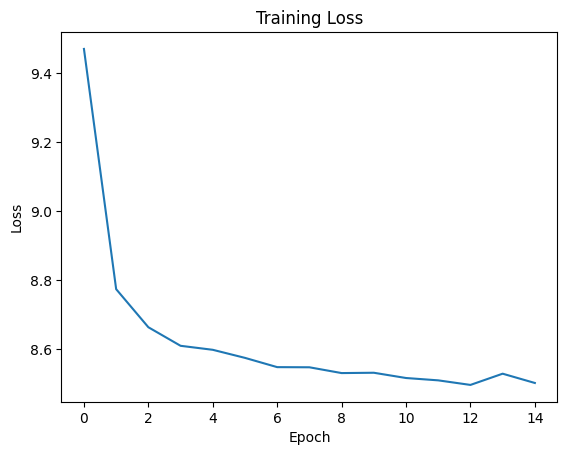

In [51]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback to stop training if the loss doesn't improve
early_stopping = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)

# Train the transformer model on the full input and target sequences
history = model.fit(X, Y, epochs=20, batch_size=256, callbacks=[early_stopping])

# Plot training loss to monitor model performance over epochs
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

We ended up with a pretty bad output. Let's see what kind of text it can generate. 

#### Step 5: Generate text with the trained model

Define a function to generate text using the trained Transformer model.

In [52]:
def generate_text(model, start_string, num_generate=100, temperature=1.0):
    # Convert the start string to a vectorized format. 
    input_eval = vectorizer([start_string]).numpy()

    # Ensure the input length is the same as the model's expected input shape.
    if input_eval.shape[1] < seq_length:
        # Pad the input if it's shorter than the expected sequence length
        padding = np.zeros((1, seq_length - input_eval.shape[1]))
        input_eval = np.concatenate((padding, input_eval), axis=1)
    elif input_eval.shape[1] > seq_length:
        # Shorten the input if it's longer than the expected sequence length
        input_eval = input_eval[:, -seq_length:]

    input_eval = tf.convert_to_tensor(input_eval)

    # Initialize an empty list to store generated text
    text_generated = []

    # Start generating text
    for i in range(num_generate):
        # Make predictions using the model
        predictions = model(input_eval)

        # Remove only the batch dimension, keep the logits as 2D (batch_size, vocab_size)
        predictions = predictions[0] # This should be of shape [vocab_size]

        # Apply temperature to predictions 
        predictions = predictions / temperature

        # Use a categorical distribution to predict the next word
        predicted_id = tf.random.categorical(predictions, num_samples=1)[0, 0].numpy()

        # Update the input tensor to include the predicted word, maintaining the sequence length
        input_eval = np.append(input_eval.numpy(), [[predicted_id]], axis=1) # Append predicted token
        input_eval = input_eval[:, -seq_length: ] # Keep only the last `seq_length` tokens
        input_eval = tf.convert_to_tensor(input_eval) # Convert back to tensor

        # Append the predicted word to the generated text
        text_generated.append(vectorizer.get_vocabulary()[predicted_id])

    # Return the generated text starting from the initial seed
    return start_string + ' ' + ' '.join(text_generated)

# Generate text with temperature control
start_string = "To be, or not to be"
generated_text = generate_text(model, start_string, temperature=0.7) # Lower temperature for more focused predictions
print(generated_text)




To be, or not to be siege duteous paly messenger midday whos froth deign likewise tempting requires kin soft lamberts happiness hard watches fancy fight heartily overmerry mounting bring thread giant shepherds bias corse heir deceiving sake nowwill forbear mocker tempter vowed usage homebred cakes ado distress forswear creep whatsoeer pink old drift burgundy lonely vented widowd music cowardice liege feeble scraping daughter commodity judgment bud firmly leanness remained broke remainder nosegays yearnd loathed exceeds pleased wounded townarmory draws merciless condemned treasure bawd rebel young rebate soils lions bianca for mellowd alike mans french mightiest singularities off palpable shakest pence oaths governd rotten tumble mystery remembers


As shown, terrible output. This probably just has to do with my hardware and data limits.